In [2]:
import pandas as pd
df = pd.read_csv("BHP.csv")
print(df.head())


              area_type   availability                  location       size  \
0  Super built-up  Area         19-Dec  Electronic City Phase II      2 BHK   
1            Plot  Area  Ready To Move          Chikka Tirupathi  4 Bedroom   
2        Built-up  Area  Ready To Move               Uttarahalli      3 BHK   
3  Super built-up  Area  Ready To Move        Lingadheeranahalli      3 BHK   
4  Super built-up  Area  Ready To Move                  Kothanur      2 BHK   

   society total_sqft  bath  balcony   price  
0  Coomee        1056   2.0      1.0   39.07  
1  Theanmp       2600   5.0      3.0  120.00  
2      NaN       1440   2.0      3.0   62.00  
3  Soiewre       1521   3.0      1.0   95.00  
4      NaN       1200   2.0      1.0   51.00  


In [3]:
print(df.shape)
print(df.columns)
print(df.info())
print(df.isnull().sum())


(13320, 9)
Index(['area_type', 'availability', 'location', 'size', 'society',
       'total_sqft', 'bath', 'balcony', 'price'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB
None
area_type          0
availability       0
location           1
size              16
society         5502
total_sqft         0
bath              73
balcony          609
price              0
dtype: int64


In [5]:

df.dropna(inplace=True)
df['bhk'] = df['size'].apply(lambda x: int(x.split()[0]))
df.drop('size', axis=1, inplace=True)


In [7]:
def convert_sqft(x):
    try:
        if '-' in x:
            a, b = x.split('-')
            return (float(a)+float(b))/2
        return float(x)
    except:
        return None

df['total_sqft'] = df['total_sqft'].apply(convert_sqft)
df.dropna(inplace=True)


In [8]:
df['price_per_sqft'] = (df['price']*100000) / df['total_sqft']


In [9]:
print(df.head())
print(df.shape)


               area_type   availability                  location  society  \
0   Super built-up  Area         19-Dec  Electronic City Phase II  Coomee    
1             Plot  Area  Ready To Move          Chikka Tirupathi  Theanmp   
3   Super built-up  Area  Ready To Move        Lingadheeranahalli  Soiewre   
5   Super built-up  Area  Ready To Move                Whitefield  DuenaTa   
11            Plot  Area  Ready To Move                Whitefield  Prrry M   

    total_sqft  bath  balcony   price  bhk  price_per_sqft  
0       1056.0   2.0      1.0   39.07    2     3699.810606  
1       2600.0   5.0      3.0  120.00    4     4615.384615  
3       1521.0   3.0      1.0   95.00    3     6245.890861  
5       1170.0   2.0      1.0   38.00    2     3247.863248  
11      2785.0   5.0      3.0  295.00    4    10592.459605  
(7481, 10)


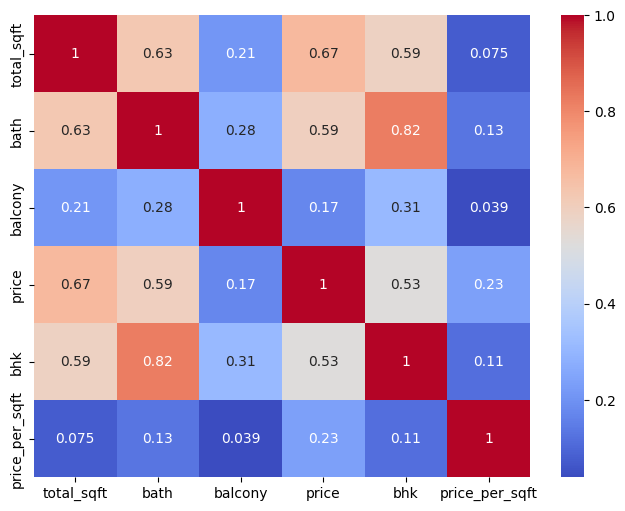

In [10]:
corr = df.select_dtypes(include='number').corr()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()


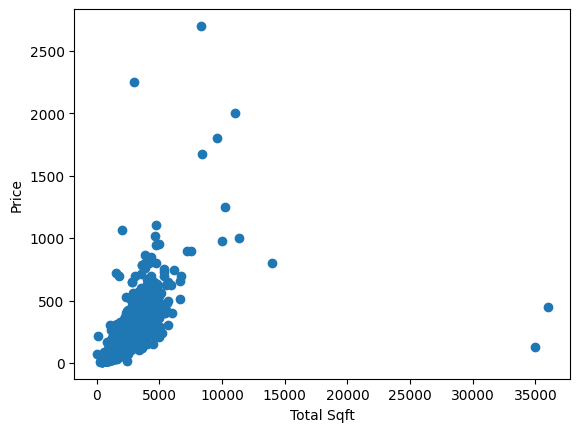

In [11]:
 plt.scatter(df['total_sqft'], df['price'])
 plt.xlabel("Total Sqft")
 plt.ylabel("Price")
 plt.show()


In [12]:
import numpy as np
import pandas as pd

def remove_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        s = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft > (m-s)) & (subdf.price_per_sqft < (m+s))]
        df_out = pd.concat([df_out, reduced_df])
    return df_out

df = remove_outliers(df)
print(df.shape)


(5359, 10)


In [13]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count'] > 5:
                exclude_indices = np.append(
                    exclude_indices,
                    bhk_df[bhk_df.price_per_sqft < stats['mean']].index.values
                )
    return df.drop(exclude_indices, axis='index')

df = remove_bhk_outliers(df)
print(df.shape)



(4178, 10)


In [14]:
df_ml = pd.get_dummies(df, drop_first=True)


In [15]:
X = df_ml.drop('price', axis=1)
y = df_ml['price']


In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

lr = LinearRegression()
lr.fit(X_train, y_train)

pred_lr = lr.predict(X_test)

print("MAE:", mean_absolute_error(y_test, pred_lr))
print("RMSE:", np.sqrt(mean_squared_error(y_test, pred_lr)))
print("R2:", r2_score(y_test, pred_lr))


MAE: 7.653812606963379
RMSE: 13.309596045345506
R2: 0.9648605398414395


In [18]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)

pred_rf = rf.predict(X_test)

print("RF R2:", r2_score(y_test, pred_rf))


RF R2: 0.9975066138301596


In [19]:
importance = rf.feature_importances_
features = X.columns

imp_df = pd.DataFrame({
    'Feature': features,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

print(imp_df.head(5))


             Feature  Importance
0         total_sqft    0.758506
4     price_per_sqft    0.206717
434  location_Yemlur    0.011342
812  society_Epllan     0.008262
2            balcony    0.002320


In [ ]:
df.to_csv("cleaned_house_price_data.csv", index=False)